In [1]:
import sys
sys.path.append("/home/webphy/Desktop/dnn_processor/")  # just to enable `dataset`
sys.path.append("/home/webphy/Desktop/dnn_processor/dataset/")  # just to enable `dataset`

import tensorflow as tf
import dataset
import numpy as np
import keras
from datetime import datetime
from keras import layers

2024-02-10 17:35:02.442066: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-10 17:35:02.466067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 17:35:02.466089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 17:35:02.466818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 17:35:02.471129: I tensorflow/core/platform/cpu_feature_guar

In [2]:
DEFAULT_BATCH_SIZE = 64
EPOCHS = 100
DEFAULT_INPUT_SIZE = 128

train_images_rgx = "../../dataset/train_set_4x/*/*.jpeg"
test_images_rgx = "../../dataset/test_set_4x/*/*.jpeg"

train_dataset, test_dataset, num_classes = dataset.create_datasets(
    train_images_rgx, test_images_rgx, DEFAULT_BATCH_SIZE, DEFAULT_INPUT_SIZE
)

2024-02-10 17:35:03.378778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 17:35:03.403253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 17:35:03.403368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# load the base line model

In [3]:
EXP_ID = "baseline_model"


model = keras.models.load_model(
    f"../handmade/saved_models/{EXP_ID}/best_model_t/model.h5",
    compile=False,
)
model.compile(
    "adam", loss=tf.keras.losses.CategoricalCrossentropy(True), metrics=["accuracy"]
)

score = model.evaluate(test_dataset)
print("Accuracy: {}".format(score[1]))

2024-02-10 17:35:05.541297: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


5/5 [==============================] - 2s 21ms/step - loss: 0.4989 - accuracy: 0.8582
Accuracy: 0.8582375645637512


# hls4ml profiling

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 32, 32, 4]
Layer name: activation, layer type: Activation, input shapes: [[None, 32, 32, 4]], output shape: [None, 32, 32, 4]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 32, 32, 4]], output shape: [None, 15, 15, 16]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 15, 15, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 15, 15, 5]], output shape: [None, 1125]
Layer name: dense, layer type: Dense, input shapes: [[None, 1125]], output shape: [None, 5]
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 

/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
   conv2d
   activation
   conv2d_1
   activation_1
   conv2d_2
   dense


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

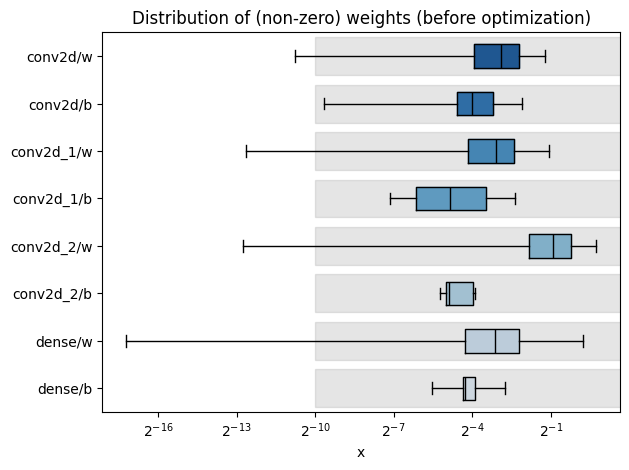

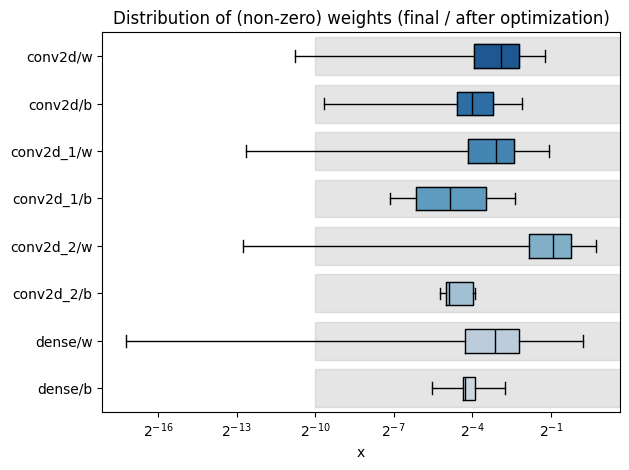

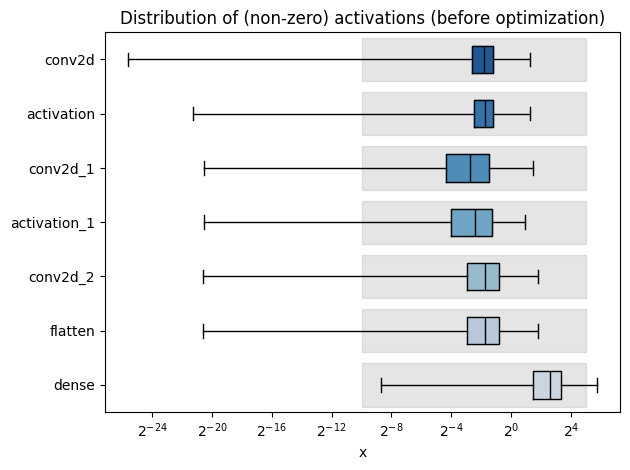

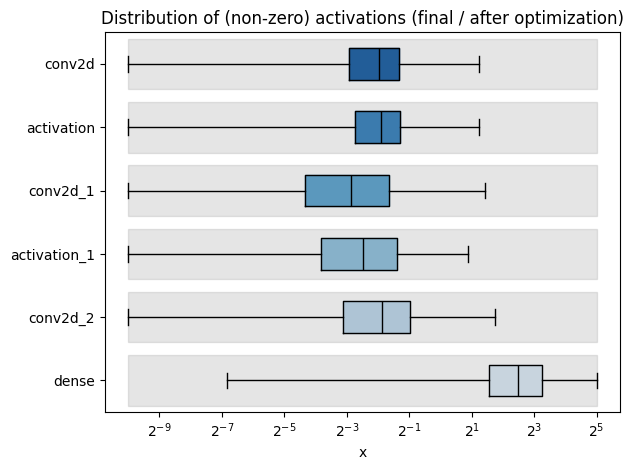

In [4]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity="name", default_precision="fixed<16,6>")

x_test = []
y_test = []
for b in test_dataset.as_numpy_iterator():
    x_test.append(b[0])
    y_test.append(b[1])

x_test = np.concatenate(x_test, 0)
y_test = np.concatenate(y_test, 0)

for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Trace"] = True

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir=f"hls4ml_data/{EXP_ID}/hls4ml_prj_2",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test)

In [5]:
hls_model.compile()

Writing HLS project


/home/webphy/Desktop/dnn_processor_v2/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [6]:
y_hls = hls_model.predict(x_test)

9/9 [==============================] - 0s 2ms/step
Keras  Accuracy: 0.8582375478927203
hls4ml Accuracy: 0.7394636015325671


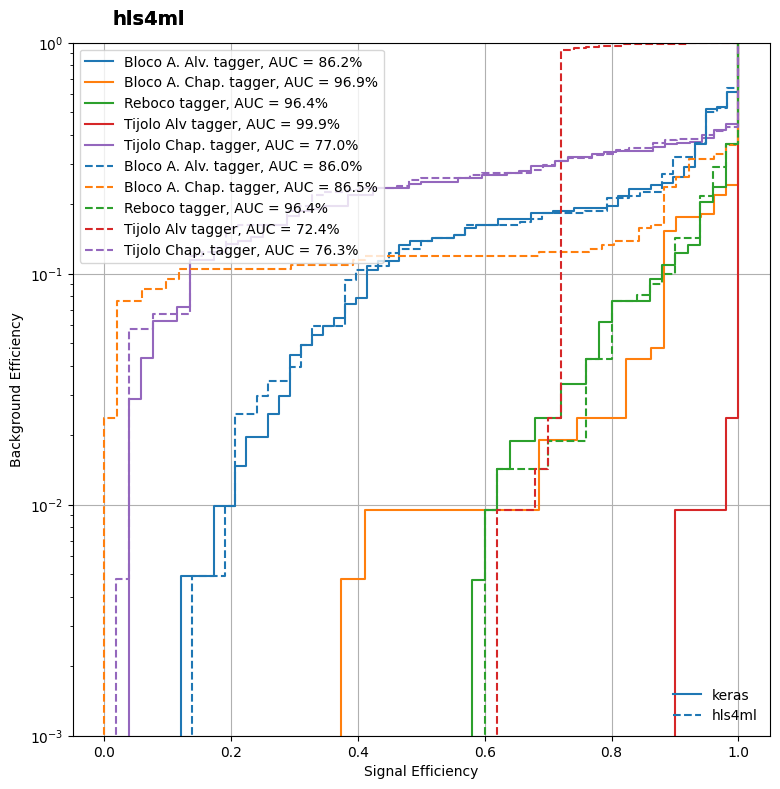

In [7]:
from sklearn.metrics import accuracy_score
import plotting
import matplotlib.pyplot as plt



y_keras = model.predict(x_test)

classes = [
    "Bloco A. Alv.",
    "Bloco A. Chap.",
    "Reboco",
    "Tijolo Alv",
    "Tijolo Chap.",
]

print(
    "Keras  Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))
    )
)
print(
    "hls4ml Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["keras", "hls4ml"], loc="lower right", frameon=False)
ax.add_artist(leg)